In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd



# Add the 'src' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'src'))
import Evaluator 

In [2]:
image_nr ="6"


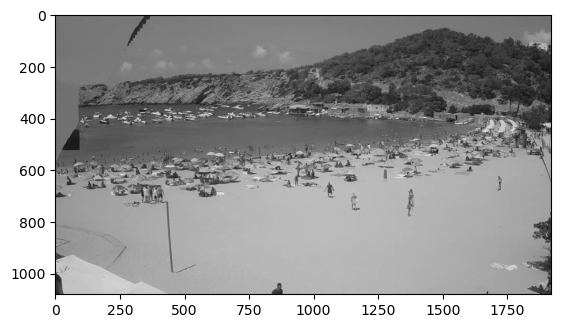

In [3]:
# Load the image
beach_occupied = cv2.imread("data/images/"+image_nr+".jpg")
# convert to RGB
beach_occupied = cv2.cvtColor(beach_occupied, cv2.COLOR_BGR2RGB)
# convert to grayscale
beach_occupied_gray = cv2.cvtColor(beach_occupied, cv2.COLOR_BGR2GRAY)
# plot image
plt.imshow(beach_occupied_gray, cmap='gray')

plt.show()


In [4]:
# plot number of person in the image load csv file with annotations

labels = pd.read_csv("data/labels/labels_"+image_nr+".csv", header=None)

# Assign column names manually, if desired
labels.columns = ['Label', 'X', 'Y', 'Image', 'Width', 'Height']
print(len(labels))

181


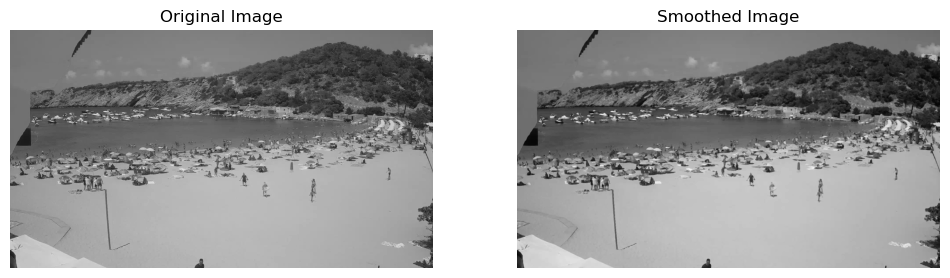

In [5]:
# Smooth image
#beach_occupied_gray_smooth = cv2.GaussianBlur(beach_occupied_gray, (5, 5), 0)
beach_occupied_gray_smooth = cv2.medianBlur(beach_occupied_gray, 5)
# plot original and smoothed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(beach_occupied_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(beach_occupied_gray_smooth, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')
plt.show()

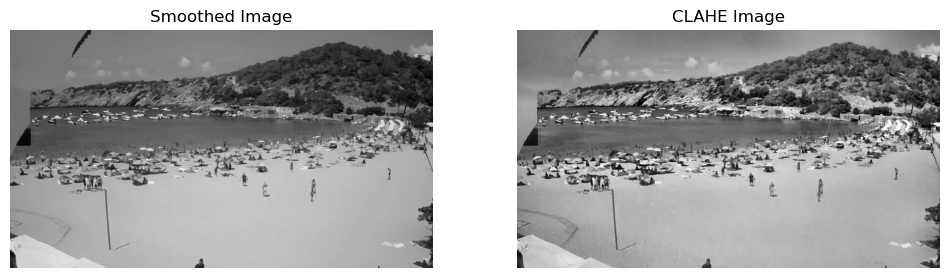

In [6]:
# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
beach_occupied_gray_clahe = clahe.apply(beach_occupied_gray_smooth)

# plot smooth and CLAHE image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(beach_occupied_gray_smooth, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(beach_occupied_gray_clahe, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')
plt.show()

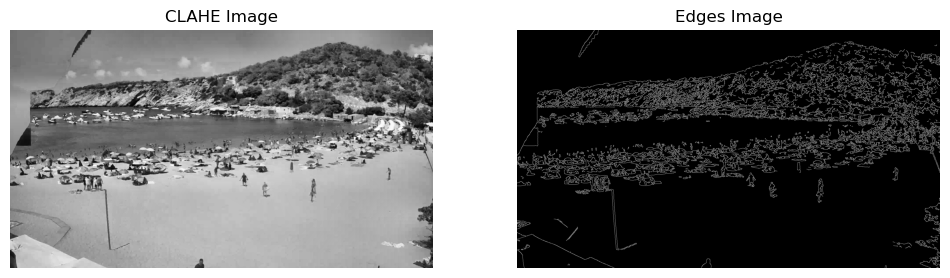

In [7]:
# detect edges
edges = cv2.Canny(beach_occupied_gray_clahe, 100, 200)
# plot CLAHE and edges
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(beach_occupied_gray_clahe, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges Image')
plt.axis('off')
plt.show()

Number of contours found = 1977


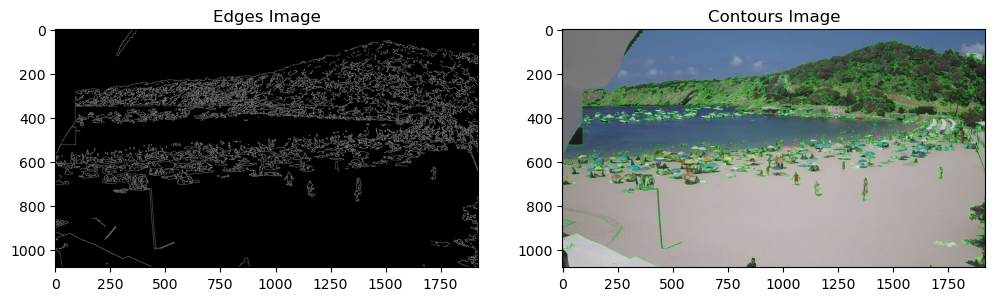

In [8]:
# find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# draw contours
beach_occupied_contours = cv2.drawContours(beach_occupied.copy(), contours, -1, (0, 255, 0), 1)


# print number of contours
print(f'Number of contours found = {len(contours)}')

# plot edges and contours
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges Image')
plt.subplot(1, 2, 2)
plt.imshow(beach_occupied_contours, cmap='gray')
plt.title('Contours Image')
plt.show()


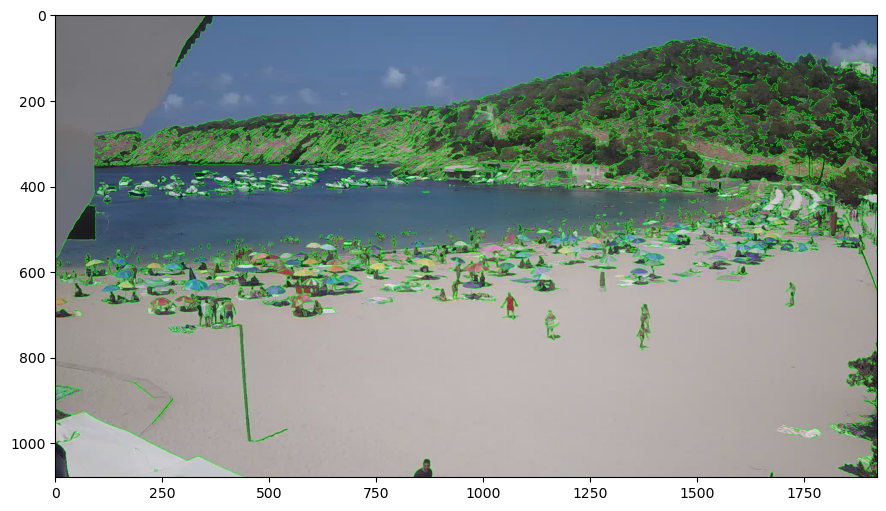

In [9]:
# plot beach_occupied image with contours in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_contours)
plt.show()

### Location-Based Filtering


Number of contours found = 751


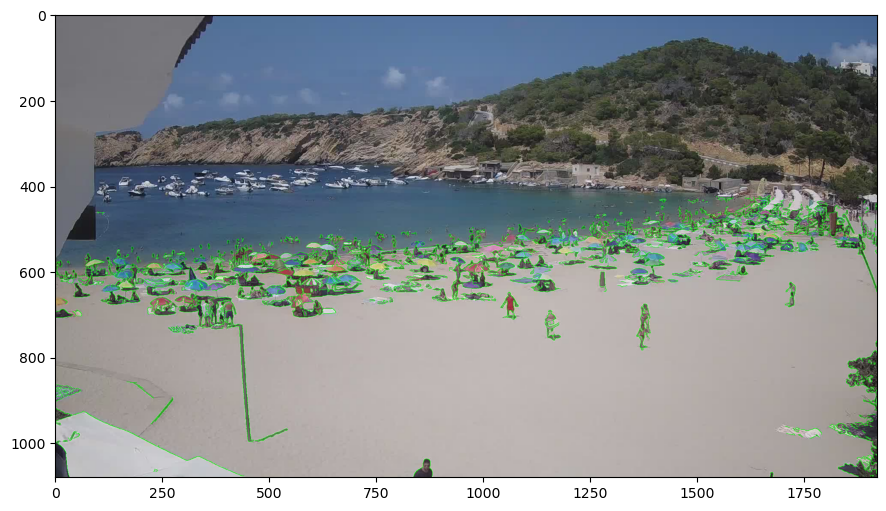

In [10]:
# remove all contours which have a y coordinate lower than 450 and a x coordinate lower than 1000 
contours_lower_left = [contour for contour in contours if cv2.boundingRect(contour)[1] > 450 and cv2.boundingRect(contour)[0] < 1000]
contours_lower_right = [contour for contour in contours if cv2.boundingRect(contour)[1] > 420 and cv2.boundingRect(contour)[0] > 1000]

# put all contours together
contours_filtered_loc = contours_lower_left + contours_lower_right

# draw contours
beach_occupied_contours = cv2.drawContours(beach_occupied.copy(), contours_filtered_loc, -1, (0, 255, 0), 1)

# print number of contours
print(f'Number of contours found = {len(contours_filtered_loc)}')

# plot beach_occupied image with contours in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_contours)
plt.show()

In [11]:
from scipy.ndimage import gaussian_filter1d

def calculate_curvature(contour):
    # Convert contour to Nx2 format if necessary
    contour = contour[:, 0, :]
    
    # Ensure the contour has enough points
    if len(contour) < 3:
        raise ValueError("Contour has too few points to calculate curvature.")
    
    # Extract x and y coordinates
    x = contour[:, 0]
    y = contour[:, 1]
    
    # Optional: Smooth the contour to reduce noise
    x = gaussian_filter1d(x, sigma=1)
    y = gaussian_filter1d(y, sigma=1)
    
    # Compute first and second derivatives
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-8
    curvature = np.abs(dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + epsilon)
    
    return np.mean(curvature)

Number of contours found = 742


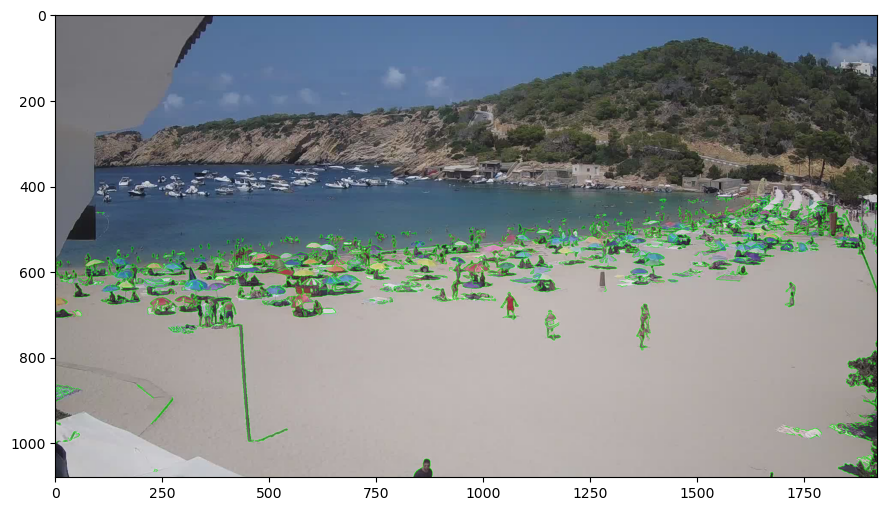

In [12]:
contours_filtered_size = []
for contour in contours_filtered_loc:
    arc_length = cv2.arcLength(contour, closed=True)
    if arc_length > 50:
        # Check curvature for contours with arc length > 100
        if np.any(calculate_curvature(contour) > 0.1):  # Ensure at least one point satisfies curvature > 0.1
            contours_filtered_size.append(contour)
    else:
        # Keep all contours with arc length <= 100
        contours_filtered_size.append(contour)
# draw contours
beach_occupied_contours = cv2.drawContours(beach_occupied.copy(), contours_filtered_size, -1, (0, 255, 0), 1)

# print number of contours
print(f'Number of contours found = {len(contours_filtered_size)}')

# plot beach_occupied image with contours in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_contours)
plt.show()


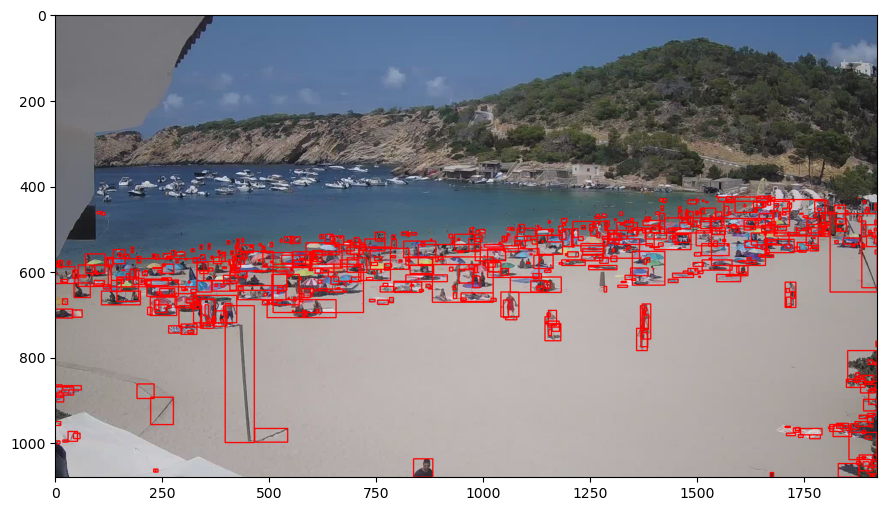

In [13]:
# get bounding boxes of contours
boxes = [cv2.boundingRect(cnt) for cnt in contours_filtered_size]

# draw bounding boxes
beach_occupied_bboxes = beach_occupied.copy()
for x, y, w, h in boxes:
    cv2.rectangle(beach_occupied_bboxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot beach_occupied image with bounding boxes in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes)
plt.show()

Number of bounding boxes found = 471


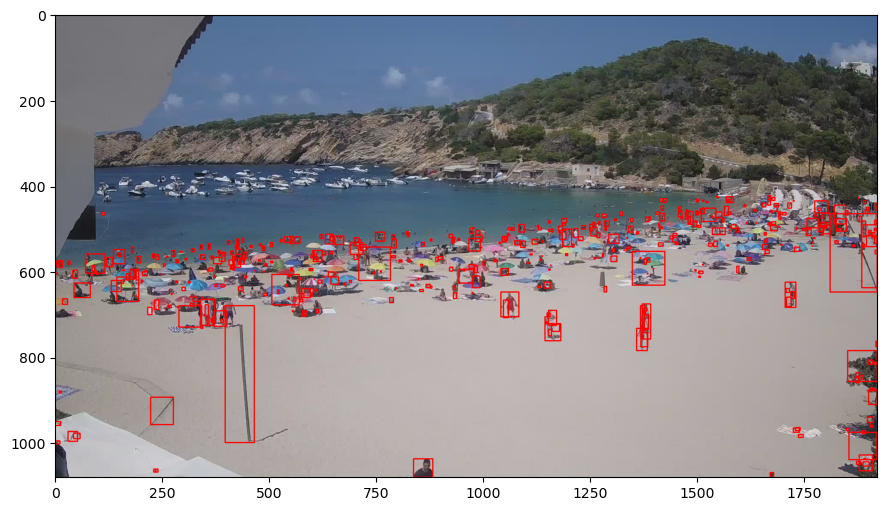

In [14]:
# remove all boxes that where the width is bigger than the height by a delta of 20
boxes_filtered_vertical = [box for box in boxes if box[2] -  box[3] < 5]
print(f'Number of bounding boxes found = {len(boxes_filtered_vertical)}')

# draw bounding boxes
beach_occupied_bboxes_filtered_vertical = beach_occupied.copy()
for x, y, w, h in boxes_filtered_vertical:
    cv2.rectangle(beach_occupied_bboxes_filtered_vertical, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot beach_occupied image with bounding boxes in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes_filtered_vertical)
plt.show()

Number of boxes found = 365


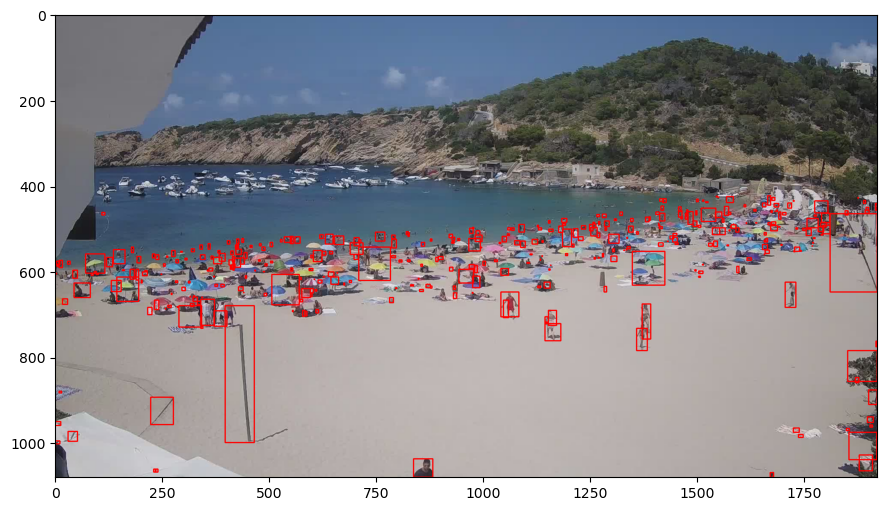

In [15]:
# Apply NMS to remove overlapping bounding boxes

def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    # compute the area of the bounding boxes
    area = boxes[:, 2] * boxes[:, 3]
    # sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # find the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have sufficient overlap
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked
    return boxes[pick]

# convert boxes to numpy array
boxes_np = np.array(boxes_filtered_vertical)
# apply non-maximum suppression
boxes_suppressed = non_max_suppression(boxes_np, 0.5)

print(f'Number of boxes found = {len(boxes_suppressed)}')

# draw bounding boxes
beach_occupied_bboxes = beach_occupied.copy()
for x, y, w, h in boxes_suppressed:
    cv2.rectangle(beach_occupied_bboxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot beach_occupied image with bounding boxes in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes)
plt.show()

Number of bounding boxes found = 363


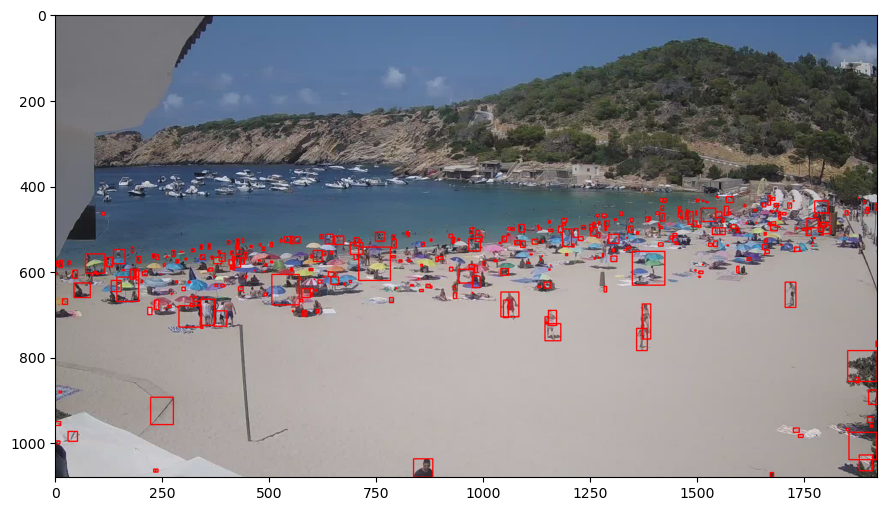

In [16]:


# remove bounding boxes with a width or high larger than 150
boxes_filtered = [box for box in boxes_suppressed if box[2] < 150 and box[3] < 150]

print(f'Number of bounding boxes found = {len(boxes_filtered)}')

# draw bounding boxes
beach_occupied_bboxes_filtered = beach_occupied.copy()
for x, y, w, h in boxes_filtered:
    cv2.rectangle(beach_occupied_bboxes_filtered, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot beach_occupied image with bounding boxes in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes_filtered)
plt.show()

Number of bounding boxes found = 267


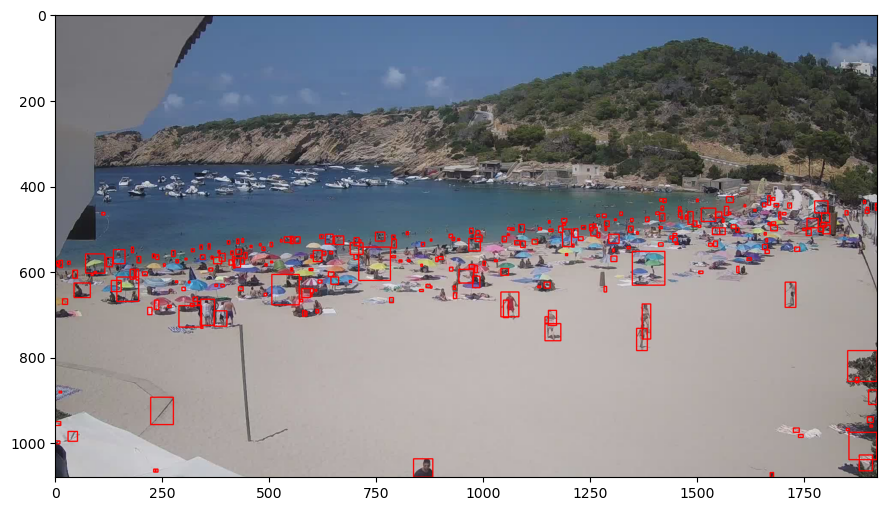

In [17]:
# remove all boxes that have a width or height smaller than 3
boxes_filtered_size = [box for box in boxes_filtered if box[2] > 3 and box[3] > 3]
print(f'Number of bounding boxes found = {len(boxes_filtered_size)}')

# draw bounding boxes
beach_occupied_bboxes_filtered_size = beach_occupied.copy()
for x, y, w, h in boxes_filtered_size:
    cv2.rectangle(beach_occupied_bboxes_filtered_size, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot beach_occupied image with bounding boxes in full size
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes_filtered_size)

In [18]:
# get the column X and Y from the labels and put them as a tupel in a np array
labels_np = labels[['X', 'Y']].to_numpy()

boxes_final = boxes_filtered_size

# evaluate the model
eval = Evaluator.Evaluator()
eval.evaluate_bounding_boxes(boxes_final, labels_np)






In [19]:
# print confusion matrix
print(eval.get_confusion_matrix())

print(f'Precision = {eval.get_precision():.4f}')
print(f'Recall = {eval.get_recall():.4f}')
print(f'F1 Score = {eval.get_f1_score():.4f}')

                     Detected   Not Detected
Actual Person              101           166
Actual not a Person         80             0
Precision = 0.3783
Recall = 0.5580
F1 Score = 0.4509


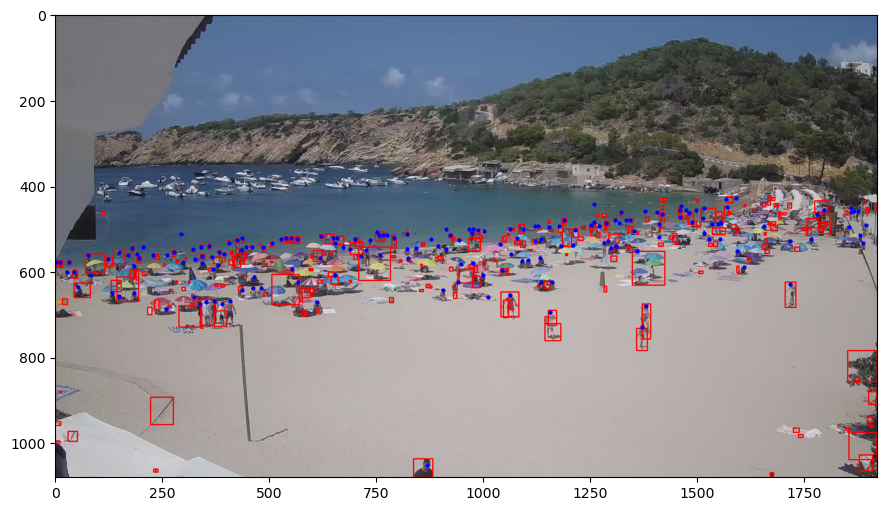

In [20]:
# plot bounding boxes and labels coordinates
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_bboxes_filtered_size)

for x, y, w, h in boxes_final:
    plt.plot(x + w / 2, y + h / 2, 'r')

for x, y in labels_np:
    plt.plot(x, y, 'bo', markersize=2)
    #change the size of the point


plt.show()

TP = 101
FP = 166
FN = 80


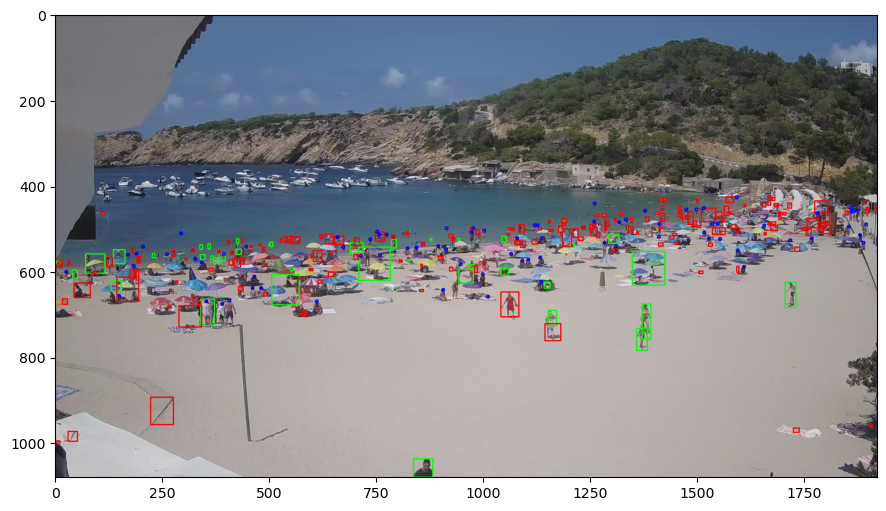

In [21]:
# Plot only the TP bounding boxes
tp_boxes,fp_boxes,fn_points = eval.get_bounding_boxes()

print(f'TP = {len(tp_boxes)}')
print(f'FP = {len(fp_boxes)}')
print(f'FN = {len(fn_points)}')

beach_occupied_tp = beach_occupied.copy()
for x, y, w, h in tp_boxes:
    cv2.rectangle(beach_occupied_tp, (x, y), (x + w, y + h), (0, 255, 0), 2)

# draw fp
for x, y, w, h in fp_boxes:
    cv2.rectangle(beach_occupied_tp, (x, y), (x + w, y + h), (255, 0, 0), 2)

# draw fn
for x, y in fn_points:
    cv2.circle(beach_occupied_tp, (x, y), 3, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_tp)
plt.show()

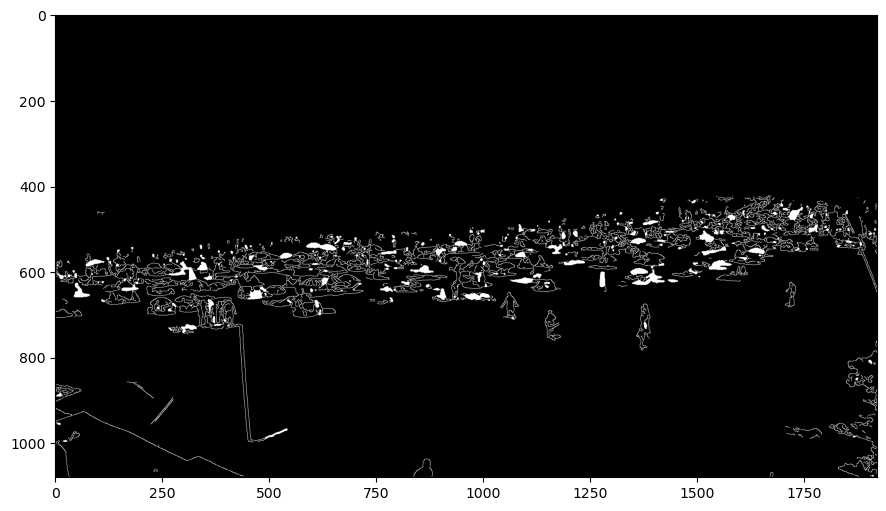

In [451]:
# Create a blank mask to redraw the filtered contours
mask = np.zeros_like(beach_occupied, dtype=np.uint8)

# Draw the location-filtered contours on the mask
cv2.drawContours(mask, contours_filtered_loc, -1, (255, 255, 255),-1)  # Fill the contours

# plot mask


# plot beach_occupied image with outermost contours in full size
plt.figure(figsize=(12, 6))
plt.imshow(mask, cmap='gray')
plt.show()


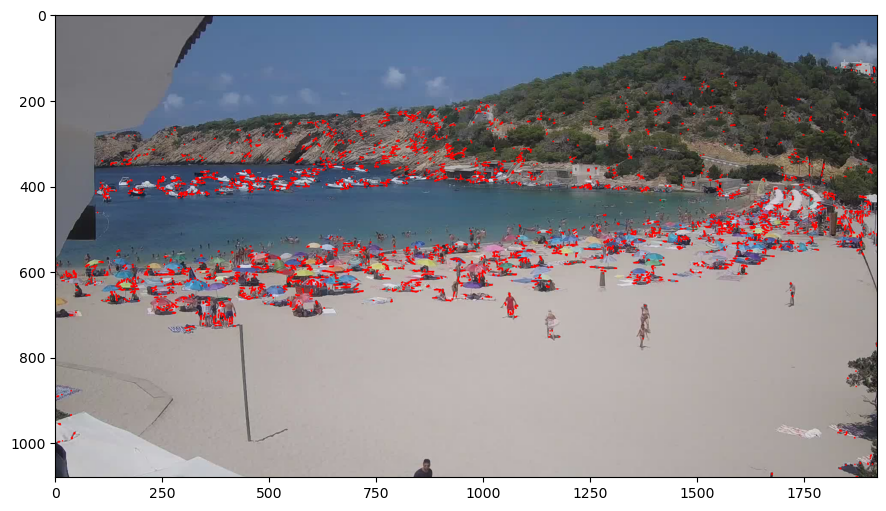

In [413]:
# detect corners with harris corner detection, use clahed image

harris_corners = cv2.cornerHarris(beach_occupied_gray_clahe, 2, 3, 0.04)
harris_corners = cv2.dilate(harris_corners, None)
corners = beach_occupied.copy()
corners[harris_corners > 0.01 * harris_corners.max()] = [255, 0, 0]

# plot corners
plt.figure(figsize=(12, 6))
plt.imshow(corners)
plt.show()



